# MTA Turnstile Data Analysis
Project 1 of **METIS** Data Science Bootcamp

---

**Background**:
- WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As we are new and inclusive organization, we try to do double duty with the gala both to fill our event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach.  
- To this end, WTWY will place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to our gala.

>**Project objective:**
- Analyze the MTA Dataset (& other data), to identify the best location for placement of street teams

---

**Useful Resources**:
- Source of MTA Turnstile data for [2018](https://catalog.data.gov/dataset/turnstile-usage-data-2018)
- Description of columns in MTA [Turnstile Data](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)
- [Annual subway ridership](http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm), to verify our analysis 

___

### Importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

### Importing dataset 

In [2]:
df = pd.read_csv('../../rawdata/Turnstile_Usage_Data__2018.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10111471 entries, 0 to 10111470
Data columns (total 11 columns):
C/A                                                           object
Unit                                                          object
SCP                                                           object
Station                                                       object
Line Name                                                     object
Division                                                      object
Date                                                          object
Time                                                          object
Description                                                   object
Entries                                                       int64
Exits                                                         int64
dtypes: int64(2), object(9)
memory usage: 848.6+ MB


In [3]:
df.columns

Index(['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date',
       'Time', 'Description', 'Entries',
       'Exits                                                     '],
      dtype='object')

### Cleaning dataset


**Challenges** in working with this dataset:
- _Entries_ and _Exits_ are cumulative count per device. So each of these observations correspond to a larger value from the previous timepoint
- There are duplicates in these observations
- Some of these counters also reset by themselves, and some of them start off with extremely large values without indication of (prevoius) historical records

In [4]:
# Renaming Odd-Spacing in Columns

df.rename(columns= {'Line Name': 'Linename', 
                    'Exits                                                     ':'Exits'},
          inplace=True)


In [5]:
# formatting dates to datetime, so we can manipulate it
# df['TIMESTAMP'] = pd.to_datetime((df.Date + ' ' + df.Time), format='%m/%d/%Y %H:%M:%S')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')


In [6]:
# Creating new column, UnitSCP as unique turnstile identifier
df['UnitSCP'] = df['Unit'].map(str) + '-' + df['SCP'].map(str)

In [7]:
# Sorting data based on Station, UnitSCP, Date and Time
# and removing duplicates

df = df.sort_values(['Station','UnitSCP','Date','Time'],
                         ascending=[True, True, True, True]).drop_duplicates()

In [8]:
# Calculate actual counts from the cumulative entries and exits
# i.e., Subtracting each row with one observation above it

df['EntriesCount'] = df['Entries'].diff(periods=1)
df['ExitsCount']= df['Exits'].diff(periods=1)

# Flag rows that are start of device switches in data
df['SwitchDevice']= df['SCP'] == df['SCP'].shift()

In [9]:
# remove negative values and beginning of device counts

df.loc[df.SwitchDevice == False, 'EntriesCount'] = 0
df.loc[df.SwitchDevice == False, 'ExitsCount'] = 0
df.loc[df.EntriesCount < 0, 'EntriesCount'] = 0
df.loc[df.ExitsCount < 0, 'ExitsCount'] = 0


In [10]:
# checking for outliers to entries/exits count
print('Maximum of EntriesCount is: '+str(df['EntriesCount'].max()))
print('Maximum of ExitsCount is: '+str(df['ExitsCount'].max()))
print('Median of EntriesCount is: '+str(df['EntriesCount'].median()))
print('Median of ExitsCount is: '+str(df['ExitsCount'].median()))
print('Standard deviation of EntriesCount is: '+str(df['EntriesCount'].std()))
print('Standard deviation  of ExitsCount is: '+str(df['ExitsCount'].std()))

Maximum of EntriesCount is: 2142302244.0
Maximum of ExitsCount is: 2145033386.0
Median of EntriesCount is: 70.0
Median of ExitsCount is: 49.0
Standard deviation of EntriesCount is: 2427107.92176231
Standard deviation  of ExitsCount is: 2773918.9822317357


In [18]:
# Making new columns to start EDA
# 'traffic' - is our new metric of how busy is each station

df['month'] = df.Date.dt.month
df['dayOfMonth'] = df.Date.dt.day
df['hour'] = df.Time.dt.hour
df['dayOfWeek'] = df.Date.dt.dayofweek
df['traffic'] = df.EntriesCount + df.ExitsCount

Text(0.5, 1.0, 'Histogram of EntriesCount during June for Penn Station')

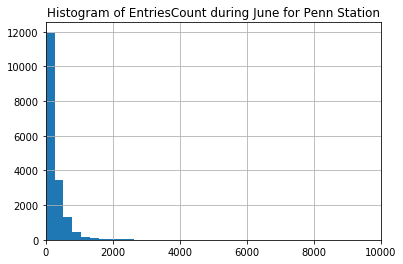

In [19]:
# checking distribution of entries and exits count for one of the busier stations
data=df.loc[(df['Station']=='34 ST-PENN STA') & (df['month']==6),['EntriesCount']]
data.hist()
plt.xlim(0,10000)
plt.title('Histogram of EntriesCount during June for Penn Station')

Text(0.5, 1.0, 'Histogram of ExitsCount during June for Penn Station')

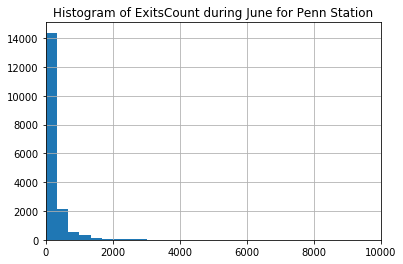

In [20]:
data2 =df.loc[(df['Station']=='34 ST-PENN STA') & (df['month']==6),['ExitsCount']]
data2.hist()
plt.xlim(0,10000)
plt.title('Histogram of ExitsCount during June for Penn Station')

In [21]:
# Removing outliers of entriesCount and ExistCount > 5000
df.loc[df.EntriesCount>5000,'EntriesCount'] = 0
df.loc[df.ExitsCount >5000, 'ExitsCount'] = 0

# Removing duplicates
df.loc[df.Description=='RECOVR AUD','EntriesCount'] = 0
df.loc[df.Description=='RECOVR AUD', 'ExitsCount'] = 0

In [22]:
df.head()

,C/A,Unit,SCP,Station,Linename,Division,Date,Time,Description,Entries,...,TIMESTAMP,UnitSCP,EntriesCount,ExitsCount,SwitchDevice,month,dayOfMonth,hour,dayOfWeek,traffic
10086039,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 03:00:00,REGULAR,13044867,...,2017-12-23 03:00:00,R248-00-00-00,0.0,0.0,False,12,23,3,5,0.0
10090698,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 07:00:00,REGULAR,13044914,...,2017-12-23 07:00:00,R248-00-00-00,47.0,131.0,True,12,23,7,5,178.0
10095363,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 11:00:00,REGULAR,13045163,...,2017-12-23 11:00:00,R248-00-00-00,249.0,472.0,True,12,23,11,5,721.0
10100042,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 15:00:00,REGULAR,13045687,...,2017-12-23 15:00:00,R248-00-00-00,524.0,624.0,True,12,23,15,5,1148.0
10104717,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 19:00:00,REGULAR,13046175,...,2017-12-23 19:00:00,R248-00-00-00,488.0,748.0,True,12,23,19,5,1236.0


### Storing 'clean' dataframe as pickle object

In [25]:
import pickle

with open('cleanDf.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

### Start Exploratory Data Analysis

**Our approach**:
- Considering that **higher volume** of traffic may mean **higher chances** of meeting people and getting signatures, we'd like to target the busiest stations

In [16]:
df.head()

,C/A,Unit,SCP,Station,Linename,Division,Date,Time,Description,Entries,...,TIMESTAMP,UnitSCP,EntriesCount,ExitsCount,SwitchDevice,month,dayOfMonth,hour,dayOfWeek,traffic
10086039,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 03:00:00,REGULAR,13044867,...,2017-12-23 03:00:00,R248-00-00-00,0.0,0.0,False,12,23,3,5,0.0
10090698,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 07:00:00,REGULAR,13044914,...,2017-12-23 07:00:00,R248-00-00-00,47.0,131.0,True,12,23,7,5,178.0
10095363,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 11:00:00,REGULAR,13045163,...,2017-12-23 11:00:00,R248-00-00-00,249.0,472.0,True,12,23,11,5,721.0
10100042,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 15:00:00,REGULAR,13045687,...,2017-12-23 15:00:00,R248-00-00-00,524.0,624.0,True,12,23,15,5,1148.0
10104717,H007,R248,00-00-00,1 AV,L,BMT,2017-12-23,1900-01-01 19:00:00,REGULAR,13046175,...,2017-12-23 19:00:00,R248-00-00-00,488.0,748.0,True,12,23,19,5,1236.0


In [24]:
# Selecting stations with the most volume of traffic

dfStation = df.groupby('Station')[['traffic']].sum().sort_values(by = 'traffic', 
                                                                 ascending=False)
dfStation.head(10)

,traffic
Station,
34 ST-PENN STA,92173076.0
GRD CNTRL-42 ST,81103683.0
34 ST-HERALD SQ,66825297.0
14 ST-UNION SQ,59343937.0
TIMES SQ-42 ST,59078455.0
23 ST,54987692.0
FULTON ST,52368391.0
42 ST-PORT AUTH,50729830.0
86 ST,45577167.0


### Create functions to plot resuts

In [26]:
# Create a function to plot top N busiest station

def plotBusiest(n):
    ''' Function returns a horizontal barplot for top n busiest station
    '''
    plotf = dfStation[:n].sort_values(by='traffic').plot(kind='barh',
                                                        fontsize=12,
                                                        color='red',
                                                        figsize=(8,10))
    fig = plotf.get_figure()
    plt.grid(linestyle='--')
    plt.xlabel('Volume of Traffic (x100 mil)', fontsize=16)
    plt.ylabel('Subway Station Name', fontsize=16)
    plt.title('Top {} Busiest Subway Stations'.format(n), fontsize=20)
    plt.tight_layout()
    filename = 'Fig_Stn_top{}.png'.format(n)
    fig.savefig(filename);
    return
    

In [28]:
# function to plot traffic over columns (e.g., hour, day, etc.)

def plotByStn(columnName, n=10):
    ''' Function returns lineplot for columnName of top n stations
    Options:
        columnName : 'dayOfWeek', 'month', 'hour'
        n          : integer 
        
    '''
    
    # labels for appropriate columns
    if columnName == 'dayOfWeek':
        xticks = np.arange(0,7,1)
        xticklab = ['Mon','Tues','Wed','Thur','Fri','Sat','Sun']
        xlabel = 'Day of Week'
        ylim = 1e5, 20e6
    elif columnName == 'month':
        xticks = np.arange(1, 13, 1)
        xticklab = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug',
                  'Sept','Oct','Nov','Dec'] 
        xlabel = 'Month of Year'
        ylim = 2e6, 10e6
    elif columnName == 'hour':
        xticks = np.arange(0,25,2)
        xticklab = ['midnight'] + [str(x)+' am' for x in np.arange(2, 12,2)] + ['noon'] + [str(x)+' pm' for x in np.arange(2, 12,2)]
        xlabel = 'Hour of Day'
        ylim = 0,1000 
    else:
        return "Can't plot column, choose another column!"

    mult, rem = divmod(n,5)
    
    # Making a subset dataframe containing only top n stations
    list_top = dfStation.index[:n].tolist()
    dfStn_top = df[df.Station.isin(list_top)]
    
    # Make a list of our subsets and titles
    df_subsets = []
    subset_titles =[]
    for ind in range(0, mult):
        df_subsets.append(df[df.Station.isin(list_top[5*ind:5*(ind+1)])])
        subset_titles.append('Station Rank #{}-#{}'.format(5*ind+1, 5*(ind+1)))
        last_ind = ind
    extra_row = 0
    
    if rem != 0:
        df_subsets.append(df[df.Station.isin(list_top[-rem:])])
        subset_titles.append('Station Rank #{}-#{}'.format(5*(last_ind+1), n))
        extra_row = 1
    
    if mult == 1:
        rows = 1
    else:
        rows = mult/2 + extra_row
    
    fig, axes = plt.subplots(int(rows), 2, figsize=(16,10*rows))
    
    for idx,val in enumerate(df_subsets):
        if columnName != 'hour':
            p = sns.lineplot(columnName, 'traffic', hue='Station',
                             estimator='sum', 
                             ci=None, 
                             data=val,
                             ax=axes.flatten()[idx])
        else:
            p = sns.lineplot(columnName, 'traffic', hue='Station',
                             ci=None, 
                             data=val,
                             ax=axes.flatten()[idx])
        axes.flatten()[idx].set_xticks(xticks)
        axes.flatten()[idx].set_xticklabels(xticklab, fontsize=14)
        axes.flatten()[idx].set_title('%s' %(subset_titles[idx]), fontsize=20)
        axes.flatten()[idx].set_xlabel(xlabel, fontsize=16)
        axes.flatten()[idx].set_ylabel('Volume of Traffic', fontsize=16)
        axes.flatten()[idx].grid(which='major', linestyle='--')
        if columnName == 'hour':
            for tick in axes.flatten()[idx].get_xticklabels():
                tick.set_rotation(45)
        else:
            axes.flatten()[idx].set_ylim(ylim)


    plt.tight_layout()
    filename = 'Fig_traffic_{}.png'.format(columnName)
    fig.savefig(filename);
    return




In [27]:
# Function to get sum of columns

def plotSum(columnName, n):
    ''' Function returns SUM lineplot for columnName of top n stations
    Options:
        columnName : 'dayOfWeek', 'month', 'hour'
        n          : integer 
        
    '''
    
    # labels for appropriate columns
    if columnName == 'dayOfWeek':
        xticks = np.arange(0,7,1)
        xticklab = ['Mon','Tues','Wed','Thur','Fri','Sat','Sun']
        xlabel = 'Day of Week'
        ylim = 0, 600
    elif columnName == 'month':
        xticks = np.arange(1, 13, 1)
        xticklab = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug',
                  'Sept','Oct','Nov','Dec'] 
        xlabel = 'Month of Year'
        ylim = 1e7, 8e7
    elif columnName == 'hour':
        xticks = np.arange(0,25,2)
        xticklab = ['midnight'] + [str(x)+' am' for x in np.arange(2, 12,2)] + ['noon'] + [str(x)+' pm' for x in np.arange(2, 12,2)]
        xlabel = 'Hour of Day'
        ylim = 0,1000 
    else:
        return "Can't plot column, choose another column!"

    # Making a subset dataframe containing only top n stations
    list_top = dfStation.index[:n].tolist()
    dfStn_top = df[df.Station.isin(list_top)]
    
    # Make a list of our subsets and titles
    df_subsets = df[df.Station.isin(list_top[0:n])]
        
    fig, axes = plt.subplots(1,1, figsize=(8,5))
    
    if columnName == 'dayOfWeek' or columnName =='hour':
        p = sns.lineplot(columnName, 'traffic', color='red',
                         ci=None, 
                         data=df_subsets,
                         ax=axes)
        
    else:
        p = sns.lineplot(columnName, 'traffic', color='red',
                         estimator='sum',
                         ci=None, 
                         data=df_subsets,
                         ax=axes)
    
    axes.set_xticks(xticks)
    axes.set_xticklabels(xticklab, fontsize=14)
    axes.set_title('Traffic in Top %s Stations, by %s' %(n,columnName), fontsize=20)
    axes.set_xlabel(xlabel, fontsize=16)
    axes.set_ylabel('Volume of Traffic', fontsize=16)
    axes.grid(which='major', linestyle='--')
    if columnName == 'hour':
        for tick in axes.get_xticklabels():
            tick.set_rotation(45)
    else:
        axes.set_ylim(ylim)

    plt.tight_layout()
    
    filename = 'Fig_trafficSum_{}.png'.format(columnName)
    fig.savefig(filename);
    return

### Start Plotting

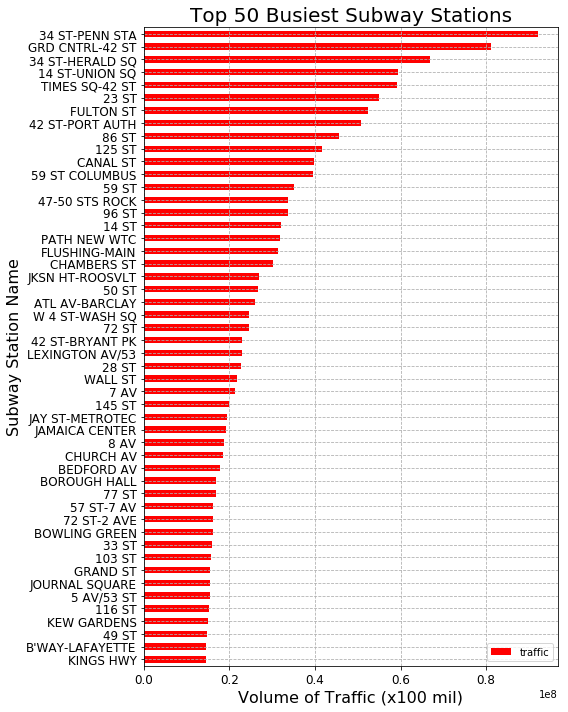

In [29]:
# Plot Traffic for Top-50 busiest 
plotBusiest(50)

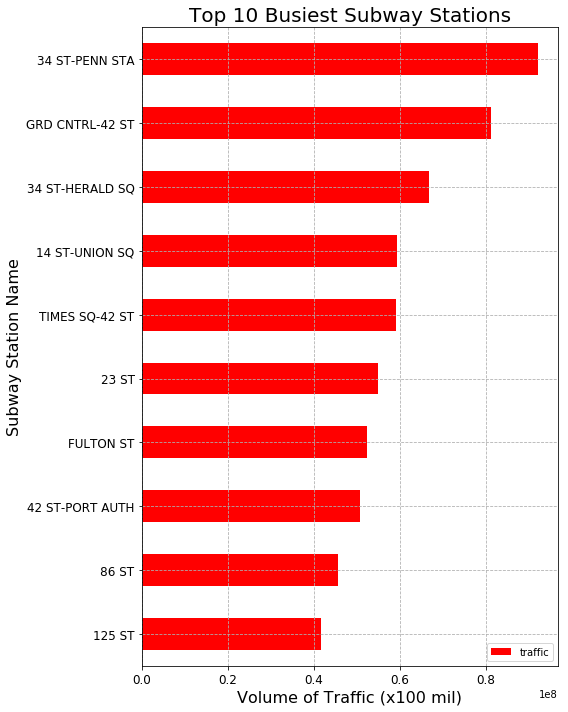

In [30]:
# Plot Traffic for Top-10 busiest 
plotBusiest(10)

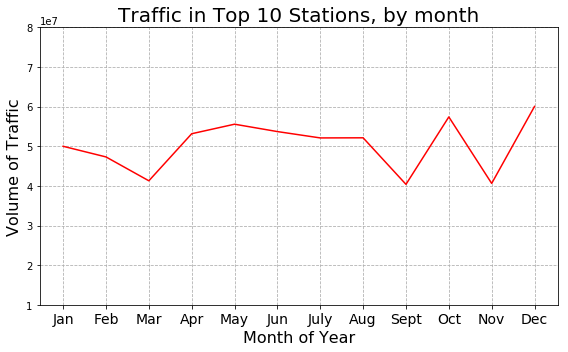

In [31]:
# PLot by Month of year
plotSum('month', 10)

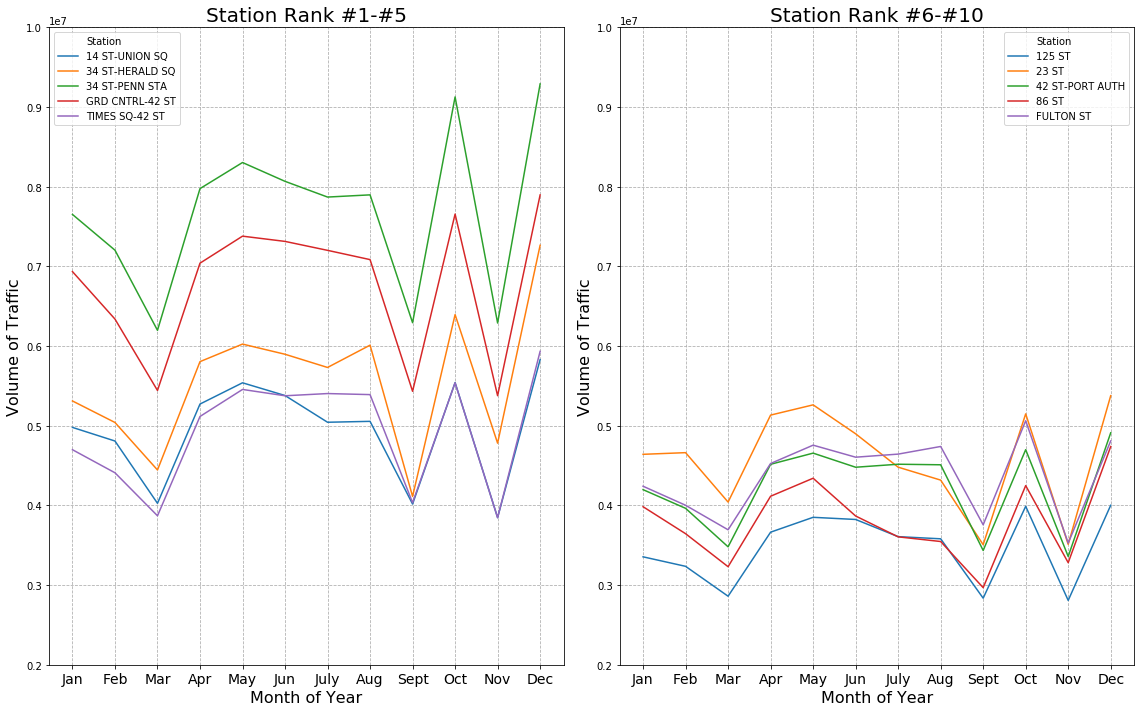

In [32]:
# Plot by Month of the year
plotByStn('month', 10)

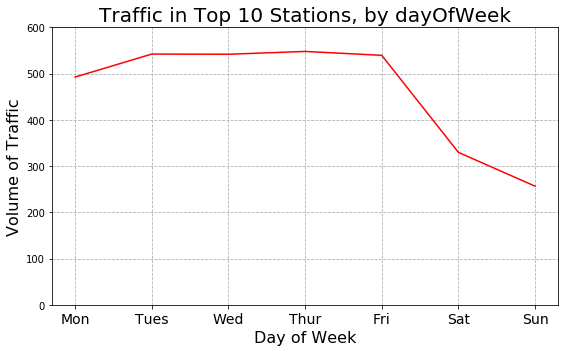

In [33]:
# PLot by Month of year
plotSum('dayOfWeek', 10)


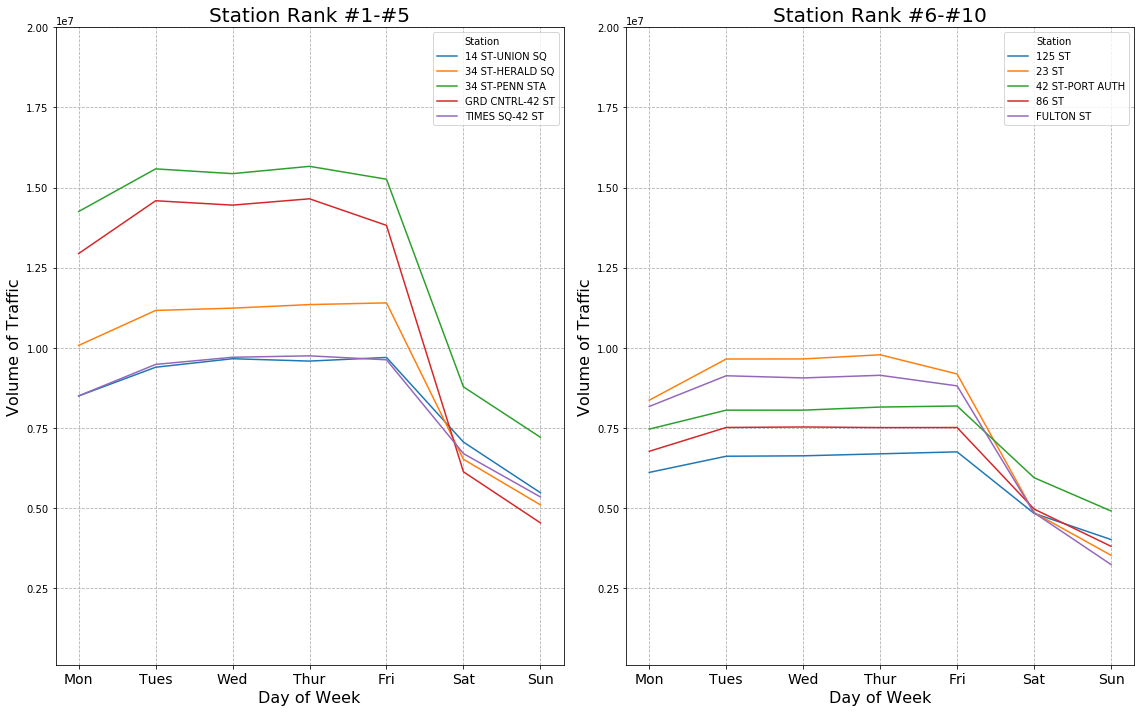

In [34]:
# Plot by Day of the Week
plotByStn('dayOfWeek', 10)

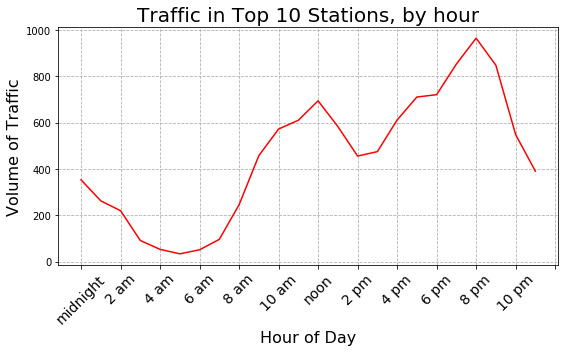

In [35]:
# PLot by Hour of day
plotSum('hour', 10)

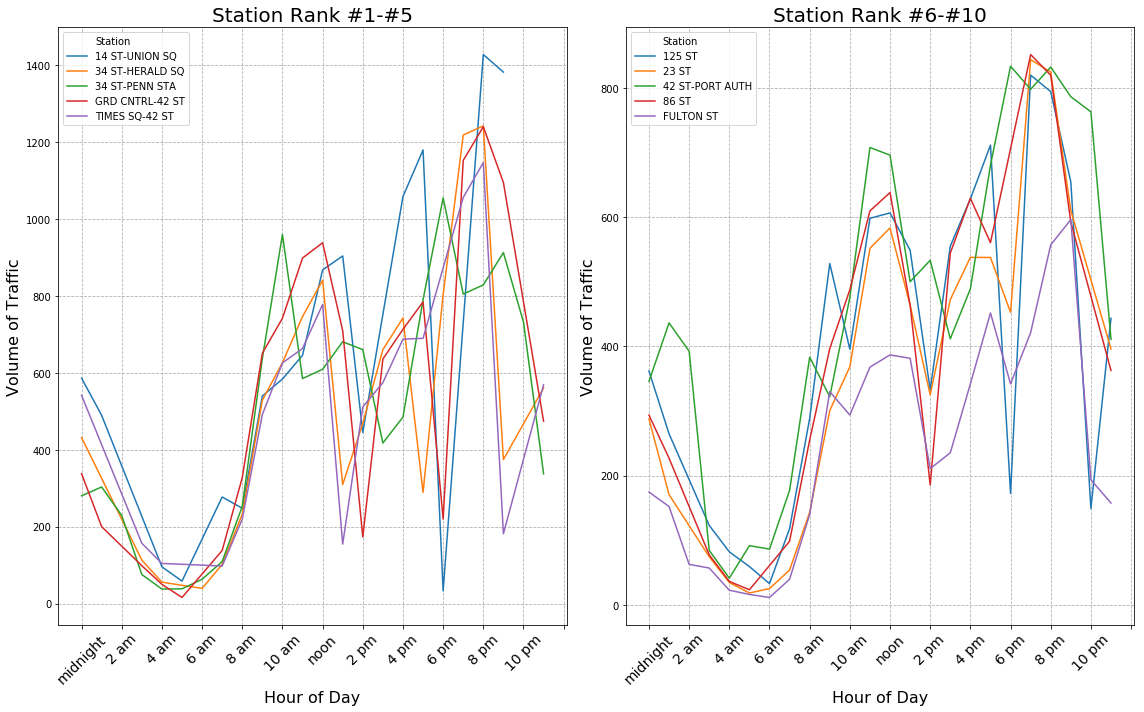

In [36]:
# Plot by Hour of the Day
plotByStn('hour', 10)

---